In [1]:
import pandas as pd
import numpy as np
import json
import string
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
import operator
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from ast import literal_eval

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier

warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import re
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D



Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
df = pd.read_csv("movies.csv")
df.head()

,movie_id,year,synopsis,genres
0,30924,2005,Cruel But Necessary is the story of Betty Muns...,Drama
1,34841,2012,"Yorkshire, 1974, the Maynard family moves into...",Drama Horror Thriller
2,23408,2017,When a renowned architecture scholar falls sud...,Drama
3,39470,1996,The story dealt with Lord Rama and his retalia...,Children Drama
4,7108,2003,A Thai playboy cons a girl into bed and then l...,Comedy Drama Horror Thriller


In [3]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35488 entries, 0 to 35487
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  35488 non-null  int64 
 1   year      35488 non-null  int64 
 2   synopsis  35488 non-null  object
 3   genres    35488 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.1+ MB


In [4]:
df = df[~(df['genres'].str.len() == 0)]

In [5]:
genres = [] 

for i in df['genres']: 
  genres.append((i.split(' '))) 

df['genres'] = genres

In [6]:
df['genres'].values[:5]


array([list(['Drama']), list(['Drama', 'Horror', 'Thriller']),
       list(['Drama']), list(['Children', 'Drama']),
       list(['Comedy', 'Drama', 'Horror', 'Thriller'])], dtype=object)

In [7]:
all_genres = sum(genres,[])
len(set(all_genres))

19

In [7]:
all_genres = nltk.FreqDist(all_genres) 
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

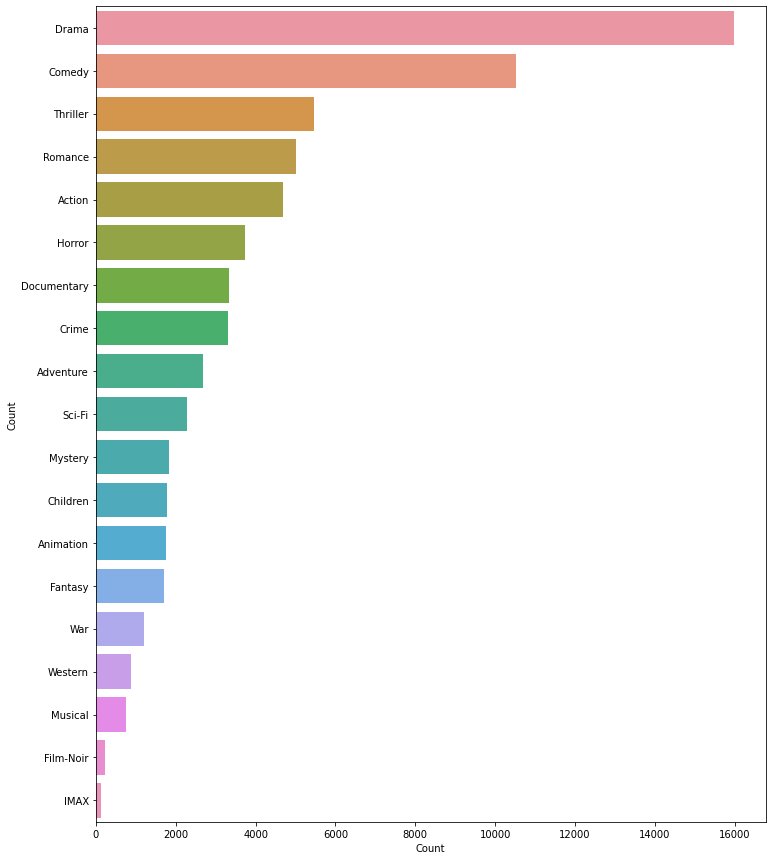

In [8]:
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

In [7]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['one', 'two', 'go','goes', 'get', 'also', 'however', 'tells'] 
stopwords_list += [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('\d+', ' ', text)
    text = text.strip(' ')
    text = word_tokenize(text)
    text = [w for w in text if w not in stopwords_list]
    text = ' '.join(text)
    return text

In [8]:
df['synopsis'] = df['synopsis'].map(lambda x : clean_text(x))


In [11]:
df['synopsis']

0        cruel necessary story betty munson strange jou...
1        yorkshire maynard family moves dream house dre...
2        renowned architecture scholar falls suddenly i...
3        story dealt lord rama retaliation ravana chara...
4        thai playboy cons girl bed leaves finding preg...
                               ...                        
35483    prequel mou gaan dou chan wing yan become unde...
35484    ann husband george son georgie arrive holiday ...
35485    former sports star fallen hard times starts co...
35486    hard hitting western drama starring mitchum or...
35487    abner peacock knotts beloved bird watcher maga...
Name: synopsis, Length: 35488, dtype: object

In [12]:
df = df.drop(columns=['year'])

In [23]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['genres'])
y = multilabel_binarizer.transform(df['genres'])
df['genres']

0                                  [Drama]
1                [Drama, Horror, Thriller]
2                                  [Drama]
3                        [Children, Drama]
4        [Comedy, Drama, Horror, Thriller]
                       ...                
35483     [Action, Crime, Drama, Thriller]
35484                    [Drama, Thriller]
35485                    [Comedy, Romance]
35486                  [Thriller, Western]
35487                             [Comedy]
Name: genres, Length: 35488, dtype: object

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df['synopsis'], y, test_size=0.2, random_state=9)

In [181]:
from sklearn.dummy import DummyClassifier
dummy_grid = {
    'estimator__strategy': ['most_frequent', 'stratified', 'prior', 'uniform', 'constant']
}
dummy = DummyClassifier( random_state = 42)
clf = OneVsRestClassifier(dummy)
dummy_gs = GridSearchCV(clf, param_grid = dummy_grid, cv = 5)
dummy_gs.fit(X_train, y_train)
print(dummy_gs.best_score_)

0.03039802747446284


In [15]:
vectorizer = TfidfVectorizer(max_df=0.8 , lowercase=False,max_features=10000)
X_train = vectorizer.fit_transform(X_train)



In [16]:
df1 = pd.DataFrame(X_train[0].T.todense(), index=vectorizer.get_feature_names(), columns=["TF-IDF"])
df1 = df1.sort_values('TF-IDF', ascending=False)
print (df1.head(25))

                TF-IDF
elisabeth     0.596736
hamburg       0.293743
happy         0.199664
dies          0.193637
long          0.155627
confusing     0.145822
disappointed  0.143896
budding       0.135986
confesses     0.133316
affections    0.132828
inherits      0.127490
time          0.125359
studies       0.122865
eric          0.121313
loyal         0.121313
stays         0.120586
love          0.116021
spent         0.113020
musician      0.109310
visits        0.108347
ready         0.108231
farm          0.104390
meeting       0.103307
asks          0.101093
although      0.100638


In [17]:
X_test = vectorizer.transform(X_test)


In [185]:
model_resultstfidf = {}
mnb_grid = {
    'estimator__alpha': [0, 0.2, 0.5, 0.8, 1.0],
    'estimator__fit_prior' : [True, False],
 'estimator__class_prior' : [None, [.4, .3, 0.08, .07, .06, .06], [.167, .167, .167, .167, .167, .167]]
}


mnb = MultinomialNB()
clf = OneVsRestClassifier(mnb)
mnb_grid = GridSearchCV(clf, param_grid = mnb_grid, cv = 5)
mnb_grid.fit(X_train, y_train)
print(mnb_grid.best_score_)

model_resultstfidf['Multinomial Bayes'] = mnb_grid.best_score_

0.20517787953504754


# LogisticRegression

In [186]:
lr_grid = {
    'estimator__penalty' : ['l1', 'l2'],
    'estimator__C' : [ 1e4, 1e10],
    'estimator__class_weight' : ['balanced', None],
    'estimator__solver' : ['lbfgs', 'liblinear'],
    'estimator__multi_class' : ['ovr', 'multinomial']
}

lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
logreg_tfidf_gs = GridSearchCV(clf, param_grid = lr_grid, cv = 5)
logreg_tfidf_gs.fit(X_train, y_train)
print(logreg_tfidf_gs.best_score_)
model_resultstfidf['Logistic Regression'] = logreg_tfidf_gs.best_score_

0.1477632969355407


In [187]:
y_pred = logreg_tfidf_gs.predict(X_test)


In [188]:
f1_score(y_test, y_pred, average="micro")


0.4744228157537347

In [189]:
ths = np.arange(.15,.3,.001)
dicth={}
for t in ths:
    y_pred_new = (y_pred_prob >= t).astype(int)
    dicth[t] = (f1_score(y_test, y_pred_new, average="micro"))


In [190]:
max(dicth.items(), key=operator.itemgetter(1))


(0.22500000000000006, 0.5720626631853786)

In [191]:
from sklearn.metrics import accuracy_score, classification_report
print('Test Accuracy score:', accuracy_score(y_test, y_pred_new))
print(classification_report(y_test, y_pred_new))

Test Accuracy score: 0.19456184840800225
              precision    recall  f1-score   support

           0       0.58      0.48      0.53       998
           1       0.59      0.23      0.33       556
           2       0.78      0.27      0.40       355
           3       0.56      0.16      0.25       360
           4       0.54      0.73      0.62      2121
           5       0.51      0.35      0.41       674
           6       0.80      0.62      0.70       654
           7       0.56      0.89      0.69      3152
           8       0.68      0.16      0.25       327
           9       0.00      0.00      0.00        46
          10       0.72      0.51      0.59       757
          11       0.00      0.00      0.00        24
          12       0.20      0.01      0.03       136
          13       0.47      0.12      0.19       374
          14       0.50      0.39      0.44       993
          15       0.72      0.37      0.49       459
          16       0.51      0.43      0

# Decision Tree

In [192]:
grid = {
    'estimator__criterion': ['gini', 'entropy'],
    'estimator__max_depth': [1, 2, 5, 10],
    'estimator__min_samples_split': [1, 5, 10, 20]
}



dt_clf = DecisionTreeClassifier (random_state = 42)
clf = OneVsRestClassifier(dt_clf)
gs_tfidf_tree = GridSearchCV(clf, param_grid = grid, cv = 5)
gs_tfidf_tree.fit(X_train, y_train)

print(gs_tfidf_tree.best_score_)
model_resultstfidf['Decision Tree'] = gs_tfidf_tree.best_score_

0.13082071151814018


# SGD

In [194]:
grid = {
    'estimator__loss' : ['hinge', 'log'],
    'estimator__penalty' : ['l2', 'l1'],
    'estimator__alpha' : [1e-3, 1e-4, 1e-5],
    'estimator__max_iter' : [20, 25, 30],
    'estimator__class_weight' : ['balanced', None]
}


sgd = SGDClassifier(random_state=42)
clf = OneVsRestClassifier(sgd)
sgd_tfidf_gs = GridSearchCV(clf, param_grid = grid, cv = 5)
sgd_tfidf_gs.fit(X_train, y_train)

print(sgd_tfidf_gs.best_score_)
model_resultstfidf['SGD'] = sgd_tfidf_gs.best_score_

0.22388164846777037


In [195]:
from sklearn.metrics import accuracy_score, classification_report
print('Test Accuracy score:', accuracy_score(y_test, y_pred_new))
print(classification_report(y_test, y_pred_new))

Test Accuracy score: 0.19456184840800225
              precision    recall  f1-score   support

           0       0.58      0.48      0.53       998
           1       0.59      0.23      0.33       556
           2       0.78      0.27      0.40       355
           3       0.56      0.16      0.25       360
           4       0.54      0.73      0.62      2121
           5       0.51      0.35      0.41       674
           6       0.80      0.62      0.70       654
           7       0.56      0.89      0.69      3152
           8       0.68      0.16      0.25       327
           9       0.00      0.00      0.00        46
          10       0.72      0.51      0.59       757
          11       0.00      0.00      0.00        24
          12       0.20      0.01      0.03       136
          13       0.47      0.12      0.19       374
          14       0.50      0.39      0.44       993
          15       0.72      0.37      0.49       459
          16       0.51      0.43      0

# LinearSVC

In [206]:
SVCpipe = Pipeline([('scale', StandardScaler()),
                   ('SVC',LinearSVC(C=1))])

In [ ]:
# Gridsearch to determine the value of C

clf = OneVsRestClassifier(SVC(kernel='linear', probability=True))
clf.fit(X_train, y_train)
proba = clf.predict_proba(X_train)

print(clf.best_score_)




In [ ]:
tuned_parameters = [
    { "estimator__gamma": [1e-3, 1e-4], "estimator__C": [1, 10, 100, 1000]}
]
svc = SVC(kernel='linear', probability=True)
clf = OneVsRestClassifier(svc)
grid_lsvc = GridSearchCV(clf, param_grid = tuned_parameters, cv = 5)
grid_lsvc.fit(X_train, y_train)

print(grid_lsvc.best_score_)


# LinearSVC

In [ ]:
SVCpipe = Pipeline([('scale', StandardScaler()),
                   ('SVC',LinearSVC(C=1))])

In [ ]:
# Gridsearch to determine the value of C

clf = OneVsRestClassifier(SVC(kernel='linear', probability=True))
clf.fit(X_train, y_train)
proba = clf.predict_proba(X_train)

print(clf.best_score_)




In [ ]:
tuned_parameters = [
    { "estimator__gamma": [1e-3, 1e-4], "estimator__C": [1, 10, 100, 1000]}
]
svc = SVC(kernel='linear', probability=True)
clf = OneVsRestClassifier(svc)
grid_lsvc = GridSearchCV(clf, param_grid = tuned_parameters, cv = 5)
grid_lsvc.fit(X_train, y_train)

print(grid_lsvc.best_score_)


In [11]:
df.head()

,movie_id,year,synopsis,genres
0,30924,2005,Cruel But Necessary is the story of Betty Muns...,[Drama]
1,34841,2012,"Yorkshire, 1974, the Maynard family moves into...","[Drama, Horror, Thriller]"
2,23408,2017,When a renowned architecture scholar falls sud...,[Drama]
3,39470,1996,The story dealt with Lord Rama and his retalia...,"[Children, Drama]"
4,7108,2003,A Thai playboy cons a girl into bed and then l...,"[Comedy, Drama, Horror, Thriller]"


# CNN

In [9]:
test_split = 0.1

# Initial train and test split.

train_df, test_df = train_test_split(df, test_size=0.2, random_state=9)
# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 28390
Number of rows in validation set: 3549
Number of rows in test set: 3549


In [220]:
genres = tf.ragged.constant(train_df["genres"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(genres)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab genres."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)


Vocabulary:

['[UNK]', 'Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Documentary', 'Crime', 'Adventure', 'Sci-Fi', 'Mystery', 'Children', 'Animation', 'Fantasy', 'War', 'Western', 'Musical', 'Film-Noir', 'IMAX']


In [11]:
sample_label = train_df["genres"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['Drama']
Label-binarized representation: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [12]:
train_df["synopsis"].apply(lambda x: len(x.split(" "))).describe()


count    28390.000000
mean        30.189010
std         18.981391
min          1.000000
25%         15.000000
50%         26.000000
75%         40.000000
max        134.000000
Name: synopsis, dtype: float64

In [13]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["genres"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["synopsis"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [14]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [15]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'documentary takes alternative approach dealing global warming crisis'
Label(s): ['Documentary']
 
Abstract: b'young child luther geek freak witnesses band men goading geek man bites chicken heads drinks blood performing ensuing hullabaloo luther bites lip likes taste blood flash forward thirty years parole board meeting discuss luther release seems cheeky blighter murdering folk meantime dopey parole board trainee sides liberals luther unleashed except special pair customized metal teeth luther proceeds bite heads many hapless folk tense ending movie notable bare dialog whole stretches pass without sound audio composed luther clucking insanely like chicken'
Label(s): ['Horror']
 
Abstract: b'olmi short young boy first love'
Label(s): ['Romance']
 
Abstract: b'social satire based best seller adele lang humorously chronicles life katya livingston self centered obnoxious conceited year old ad sales exec wo let anything anyone stand way getting top san francisco social ladder'


In [16]:
vocabulary = set()
train_df["synopsis"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

58092


In [17]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [30]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            #layers.Embedding(vocabulary_size, 100, input_length=150),
            #layers.SpatialDropout1D(0.2),
            #layers.LSTM(200, dropout=0.2, recurrent_dropout=0.2),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

Epoch 1/50
222/222 [==============================] - 11s 46ms/step - loss: 0.2269 - categorical_accuracy: 0.5014 - val_loss: 0.1883 - val_categorical_accuracy: 0.5404
Epoch 2/50
222/222 [==============================] - 10s 45ms/step - loss: 0.0684 - categorical_accuracy: 0.6309 - val_loss: 0.2309 - val_categorical_accuracy: 0.4776
Epoch 3/50
222/222 [==============================] - 11s 47ms/step - loss: 0.0177 - categorical_accuracy: 0.6664 - val_loss: 0.3363 - val_categorical_accuracy: 0.4691
Epoch 4/50
222/222 [==============================] - 10s 46ms/step - loss: 0.0076 - categorical_accuracy: 0.6995 - val_loss: 0.4053 - val_categorical_accuracy: 0.4773
Epoch 5/50
222/222 [==============================] - 10s 46ms/step - loss: 0.0055 - categorical_accuracy: 0.7111 - val_loss: 0.4314 - val_categorical_accuracy: 0.4861
Epoch 6/50
222/222 [==============================] - 11s 47ms/step - loss: 0.0063 - categorical_accuracy: 0.7104 - val_loss: 0.4747 - val_categorical_accuracy:

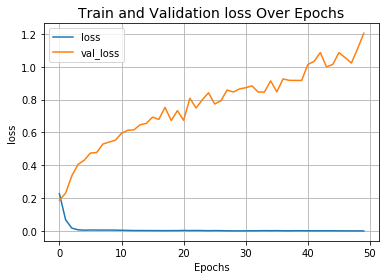

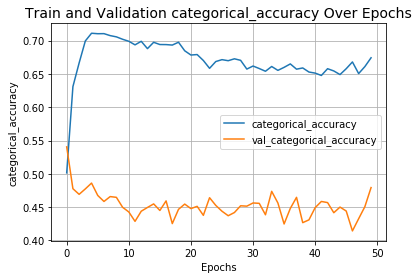

In [31]:
epochs = 50

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

In [40]:
_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")


28/28 [==============================] - 0s 13ms/step - loss: 1.2357 - categorical_accuracy: 0.4652
Categorical accuracy on the test set: 46.52%.
1.2356828451156616


In [41]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

Abstract: b'man monotonous job punching tickets japanese railway night walking home saves jun getting raped hoodlums days later sneaks house gets discovered later watches son subdue insect chemical man gets idea subdue women sleeping wo discovered sneaking home new hobby spirals control confidence grows'
Label(s): ['Drama' 'Crime']
Predicted Label(s): (Thriller, Drama, Romance)
 
Abstract: b'sarah barcant lawyer new york city grew south africa returns childhood dwelling place intercede alex mpondo black south african politician tortured apartheid'
Label(s): ['Drama']
Predicted Label(s): (Drama, Thriller, Children)
 
Abstract: b'city life death takes place height second sino japanese war imperial japanese army captured capital republic china nanjing followed known nanking massacre rape nanking period several weeks wherein tens thousands chinese soldiers civilians killed'
Label(s): ['Drama' 'War']
Predicted Label(s): (Drama, War, Documentary)
 
Abstract: b'wrongly time prison murder man 